<a href="https://colab.research.google.com/github/Judy-Choi/Tensorflow_Certificate/blob/main/6.cats_vs_dogs_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal Metric
- val_loss : 0.24087
- val_acc : 0.9082

# CNN과 Transfer Learning으로 cats vs dogs 문제를 풀어봅시다

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16

from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# 1. 데이터셋 준비
### train data 80% test data 20%
### `BATCH_SIZE`와 `EPOCHS`(시간상 5) 를 정의합니다. 나중에 따로 EPOCHS = 20으로 하고 돌려보시길 바랍니다.

In [ ]:
BATCH_SIZE = 32
EPOCHS = 20
dataset_name = 'cats_vs_dogs'
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(train_dataset, validation_dataset), info = tfds.load(name=dataset_name, split=('train[:80%]', 'train[-20%:]'), with_info=True)

# 2. 데이터 프리프로세싱

이미지에 대한 Normalization 합니다.
이미지는 0 ~ 255 까지 integer. tf.cast는 float로 바꾸고 255로 나누면 0~1까지 소수로 변경됨. 이미지는 모두 같은 size로 만들어야 tensorflow에 입력이 가능함

In [ ]:
def normalize(images):
    # 0~1 사이의 값으로 Normalize 합니다.
    img, lbl = tf.cast(images['image'], tf.float32) / 255.0, images['label']
    # 224 X 224 사이즈로 resize 합니다.
    img = tf.image.resize(img, size=(224, 224))
    return img, lbl

# 3. Normalize & Mini batch

`normalize`를 수행합니다.

`Training Set`와 `Validation Set`을 만들고 **BATCH_SIZE**에 따라 mini batch를 만듭니다.

In [ ]:
train_data = train_dataset.map(normalize).batch(BATCH_SIZE)
valid_data = validation_dataset.map(normalize).batch(BATCH_SIZE)

In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# 4. 모델 설계하기(CNN) 

In [ ]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'),
    MaxPooling2D(2, 2), 
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2), 
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2), 
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2), 
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2), 
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2), 
    Flatten(), 
    Dense(64, activation='relu'), 
    Dropout(0.2),
    Dense(32, activation='relu'), 
    Dense(1, activation='sigmoid')
])

# 이진분류이므로 loss='binary_crossentropy'
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5. 모델 모니터링하기 (Callback function)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpoint_path = 'checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
        save_best_only=True, 
        save_weights_only=True, 
        monitor='val_loss', 
        verbose=1)

# 6. 모델 학습하기 (CNN) - 0.32727

In [ ]:
cnn_history = model_cnn.fit(train_data, 
                            validation_data=(valid_data),
                            epochs=EPOCHS, 
                            callbacks=[checkpoint, early_stopping])
model_cnn.load_weights(checkpoint_path)                      
model_cnn.save("cats-dogs-cnn.h5")      

Epoch 1/20
582/582 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.5968
Epoch 1: val_loss improved from inf to 0.64202, saving model to checkpoint.ckpt
582/582 [==============================] - 61s 82ms/step - loss: 0.6516 - accuracy: 0.5968 - val_loss: 0.6420 - val_accuracy: 0.6268
Epoch 2/20
581/582 [============================>.] - ETA: 0s - loss: 0.5337 - accuracy: 0.7349
Epoch 2: val_loss improved from 0.64202 to 0.51880, saving model to checkpoint.ckpt
582/582 [==============================] - 52s 89ms/step - loss: 0.5336 - accuracy: 0.7351 - val_loss: 0.5188 - val_accuracy: 0.7388
Epoch 3/20
582/582 [==============================] - ETA: 0s - loss: 0.4576 - accuracy: 0.7850
Epoch 3: val_loss improved from 0.51880 to 0.50763, saving model to checkpoint.ckpt
582/582 [==============================] - 45s 78ms/step - loss: 0.4576 - accuracy: 0.7850 - val_loss: 0.5076 - val_accuracy: 0.7420
Epoch 4/20
581/582 [============================>.] - ETA: 0s - l

In [ ]:
model_cnn.load_weights(checkpoint_path)                      
model_cnn.save("cats-dogs-cnn.h5")     

## Transfer Learning (VGG 16) - 0.16052

**VGG-16**은 ImageNet 데이터베이스의 1백만 개가 넘는 영상에 대해 훈련된 컨벌루션 신경망입니다. 이 네트워크에는 16개의 계층이 있으며, 영상을 키보드, 마우스, 연필, 각종 동물 등 1,000가지 사물 범주로 분류할 수 있습니다. 그 결과 이 네트워크는 다양한 영상을 대표하는 다양한 특징을 학습했습니다. 

**VGG-16모델**을 활용하여 Transfer Learning 을 진행합니다.

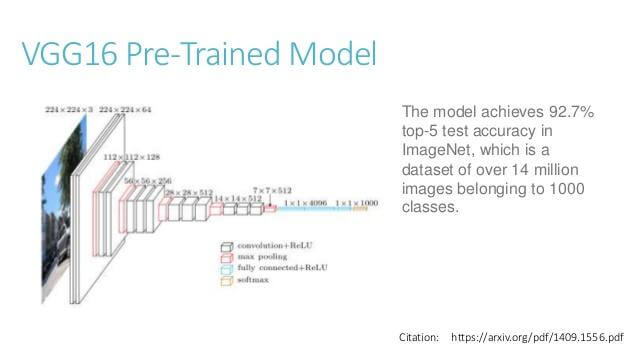

In [ ]:
from IPython.display import Image
Image('https://s3.ap-south-1.amazonaws.com/techleer/309.jpg')

include_top 은 실제 vgg16의 마지막 부분인 분류기 (softmax를 포함한 1000개 category로 분류)를 포함하냐(True), 마느냐(False)를 선택합니다. 우리는 cat 이냐 dog 이냐를 분류하려고 하므로 False로 합니다.

In [ ]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 3s 0us/step


불러오는 vgg16은 새로 학습할 것이 아니므로 trainable = False로 합니다.

In [ ]:
transfer_model.trainable=False

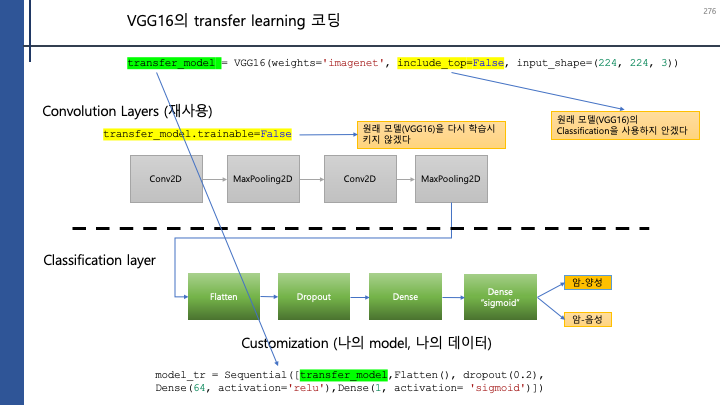

In [ ]:
model_tr = Sequential([
    transfer_model, 
    Flatten(), 
    Dense(64, activation='relu'), 
    Dense(1, activation='sigmoid')
    ])

In [ ]:
model_tr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
transfer_history = model_tr.fit(train_data, 
                             validation_data=(valid_data),
                             epochs=EPOCHS, 
                             callbacks=[checkpoint, early_stopping])
model_tr.load_weights(checkpoint_path)  
model_tr.save("cats-dogs-tr.h5")      

Epoch 1/20
582/582 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.9042
Epoch 1: val_loss improved from 0.32727 to 0.17283, saving model to checkpoint.ckpt
582/582 [==============================] - 102s 165ms/step - loss: 0.2270 - accuracy: 0.9042 - val_loss: 0.1728 - val_accuracy: 0.9280
Epoch 2/20
582/582 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9493
Epoch 2: val_loss improved from 0.17283 to 0.16052, saving model to checkpoint.ckpt
582/582 [==============================] - 90s 154ms/step - loss: 0.1289 - accuracy: 0.9493 - val_loss: 0.1605 - val_accuracy: 0.9329
Epoch 3/20
582/582 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.9528
Epoch 3: val_loss did not improve from 0.16052
582/582 [==============================] - 93s 161ms/step - loss: 0.1150 - accuracy: 0.9528 - val_loss: 0.2146 - val_accuracy: 0.9170
Epoch 4/20
582/582 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.951

## 성능 Visualization

**Losses** 와 **Accuracy**를 보면, Transfer Learning 모델이 훨씬 초기 수렴이 빠를 뿐더러, 최종 성능도 accuracy 기준 **약 10%** 가량 우수하다는 것을 확인할 수 있습니다.

In [ ]:
epochs_cnn = np.arange(1,len(cnn_history.history['accuracy'])+1)
epochs_tr = np.arange(1, len(transfer_history.history['accuracy'])+1)
print(epochs_cnn, epochs_tr)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [ ]:
cnn_history.history

{'loss': [0.6516218185424805,
  0.5335872173309326,
  0.4575822949409485,
  0.3989836275577545,
  0.3421558439731598,
  0.29986515641212463,
  0.2652745842933655,
  0.23306356370449066,
  0.2065848559141159,
  0.19247794151306152,
  0.1814938485622406,
  0.14990252256393433,
  0.14119796454906464,
  0.13410735130310059,
  0.1272629350423813,
  0.11838049441576004,
  0.10357924550771713],
 'accuracy': [0.5968296527862549,
  0.7350886464118958,
  0.7850080728530884,
  0.8204728364944458,
  0.8508866429328918,
  0.8716818690299988,
  0.8924771547317505,
  0.9035464525222778,
  0.9162278175354004,
  0.9220311641693115,
  0.9277807474136353,
  0.941106915473938,
  0.9430950880050659,
  0.9459430575370789,
  0.948683500289917,
  0.9524986743927002,
  0.9591079950332642],
 'val_loss': [0.6420229077339172,
  0.5187954902648926,
  0.5076349973678589,
  0.40439072251319885,
  0.36197593808174133,
  0.33942246437072754,
  0.32727235555648804,
  0.34988799691200256,
  0.358473539352417,
  0.392687

In [ ]:
transfer_history.history

{'loss': [0.22704464197158813,
  0.1289377212524414,
  0.11499547958374023,
  0.11549455672502518,
  0.09513327479362488,
  0.07947152853012085,
  0.05890456214547157,
  0.05039527639746666,
  0.06280066817998886,
  0.05922887101769447,
  0.056564994156360626,
  0.04357711598277092],
 'accuracy': [0.9042450189590454,
  0.9492745995521545,
  0.9528210759162903,
  0.9515314102172852,
  0.9616335034370422,
  0.9693175554275513,
  0.9781837463378906,
  0.9800107479095459,
  0.9744223356246948,
  0.9763030409812927,
  0.9772165417671204,
  0.9833422899246216],
 'val_loss': [0.17282870411872864,
  0.16052131354808807,
  0.21458981931209564,
  0.16972661018371582,
  0.17540188133716583,
  0.18654240667819977,
  0.264699250459671,
  0.4784912168979645,
  0.9867957234382629,
  0.2551705539226532,
  0.2552814781665802,
  0.3207537829875946],
 'val_accuracy': [0.9279879331588745,
  0.9329320788383484,
  0.9170249104499817,
  0.9335769414901733,
  0.9361565113067627,
  0.9299226403236389,
  0.9127

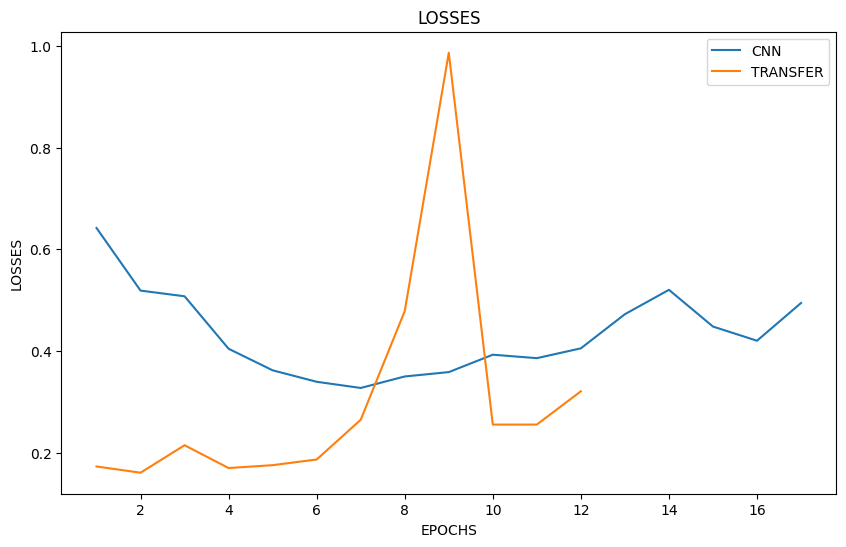

In [ ]:
if len(cnn_history.history) > len(transfer_history.history):
    EPOCHS = len(cnn_history.history)
else:
    EPOCHS = len(transfer_history.history)
plt.figure(figsize=(10, 6))
plt.plot(epochs_cnn, cnn_history.history['val_loss'], label='CNN')
plt.plot(epochs_tr, transfer_history.history['val_loss'], label='TRANSFER')
plt.xlabel('EPOCHS')
plt.ylabel('LOSSES')
plt.title('LOSSES')
plt.legend()
plt.show()

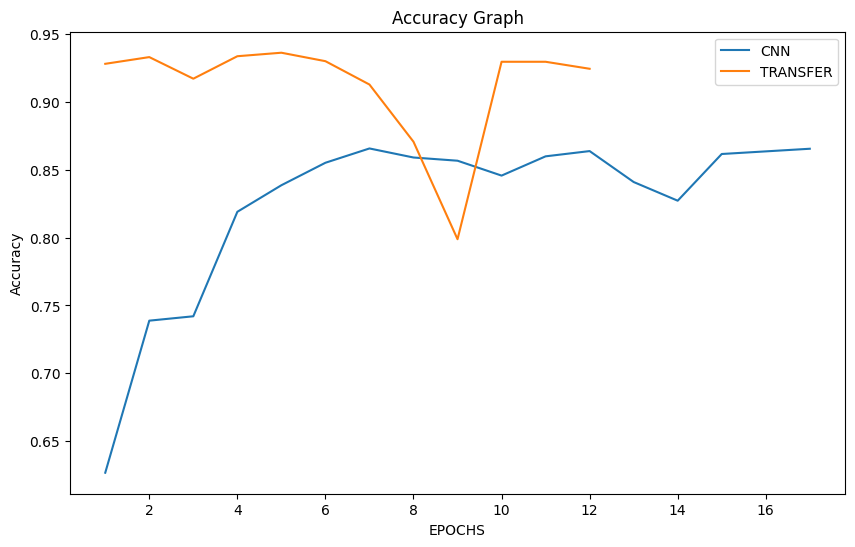

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs_cnn, cnn_history.history['val_accuracy'], label='CNN')
plt.plot(epochs_tr, transfer_history.history['val_accuracy'], label='TRANSFER')
plt.xlabel('EPOCHS')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

# Homework 1 : 직접 코딩 (CNN) - 0.69337

In [ ]:
# VGG16 따라하기
model_cnn = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2), 

    Conv2D(128, (3, 3), activation='relu', input_shape=(112, 112, 3), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2), 

    Conv2D(256, (3, 3), activation='relu', input_shape=(56, 56, 3), padding='same'), 
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2), 

    Conv2D(512, (3, 3), activation='relu', input_shape=(28, 28, 3), padding='same'), 
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2), 

    Conv2D(512, (3, 3), activation='relu', input_shape=(14, 14, 3), padding='same'), 
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2), 

    Conv2D(512, (3, 3), activation='relu', input_shape=(7, 7, 3), padding='same'), 
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2), 

    Flatten(), 
    Dense(4096, activation='relu'), 
    Dense(4096, activation='relu'), 
    Dense(1, activation='sigmoid')
])

# 이진분류이므로 loss='binary_crossentropy'
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpoint_path = 'checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
        save_best_only=True, 
        save_weights_only=True, 
        monitor='val_loss', 
        verbose=1)

cnn_history = model_cnn.fit(train_data, 
                            validation_data=(valid_data),
                            epochs=EPOCHS, 
                            callbacks=[checkpoint, early_stopping])
model_cnn.load_weights(checkpoint_path)                      
model_cnn.save("(hw)cats-dogs-cnn.h5")

Epoch 1/20
582/582 [==============================] - ETA: 0s - loss: 0.7265 - accuracy: 0.4990
Epoch 1: val_loss improved from inf to 0.69350, saving model to checkpoint.ckpt
582/582 [==============================] - 364s 589ms/step - loss: 0.7265 - accuracy: 0.4990 - val_loss: 0.6935 - val_accuracy: 0.4901
Epoch 2/20
582/582 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5037
Epoch 2: val_loss improved from 0.69350 to 0.69346, saving model to checkpoint.ckpt
582/582 [==============================] - 325s 559ms/step - loss: 0.6932 - accuracy: 0.5037 - val_loss: 0.6935 - val_accuracy: 0.4901
Epoch 3/20
582/582 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5019
Epoch 3: val_loss improved from 0.69346 to 0.69341, saving model to checkpoint.ckpt
582/582 [==============================] - 343s 590ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6934 - val_accuracy: 0.4901
Epoch 4/20
582/582 [==============================] - ETA: 

KeyboardInterrupt: ignored

In [ ]:
model_cnn.load_weights(checkpoint_path)                      
model_cnn.save("(hw)cats-dogs-cnn.h5")

# Homework 2 : 직접 코딩 (Transfer Learning) - 0.18100

In [ ]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
transfer_model.trainable=False

model_tr = Sequential([
    transfer_model, 
    Flatten(), 
    # Layer 추가
    Dense(64, activation='relu'), 
    Dense(64, activation='relu'), 
    Dense(32, activation='relu'), 
    Dense(1, activation='sigmoid')
    ])

model_tr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

transfer_history = model_tr.fit(train_data, 
                             validation_data=(valid_data),
                             epochs=EPOCHS, 
                             callbacks=[checkpoint, early_stopping])
model_tr.load_weights(checkpoint_path)
model_tr.save("(hw)cats-dogs-tr.h5")

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/20
582/582 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9055
Epoch 1: val_loss improved from 0.69339 to 0.19758, saving model to checkpoint.ckpt
582/582 [==============================] - 89s 151ms/step - loss: 0.2244 - accuracy: 0.9055 - val_loss: 0.1976 - val_accuracy: 0.9134
Epoch 2/20
582/582 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9474
Epoch 2: val_loss did not improve from 0.19758
582/582 [==============================] - 87s 150ms/step - loss: 0.1296 - accuracy: 0.9474 - val_loss: 0.2142 - val_accuracy: 0.9091
Epoch 3/20
582/582 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.9563
Epoch 3: val_loss did not improve from 0.19758
582/582 [==============================] - 87s 150ms/step - loss: 0.1088 - accuracy: 0.9563 - val_loss: 0.2093 - val_accuracy: 0.9267
Epoch 4/20
582/582 [==============================] - ETA: 0s - los

# Homework 3 : ChatGPT (CNN) - 0.69337

다음 코드를 최적화해 줘,  
단, 다음 조건을 적용해 줘  
Use dropout  
Use batch normalization  
Use checkpoint with save best only, and save weight only and verbose = 1  
Use early stopping with patience = 10  
Use reduce learning rate on plateau  
set verbose = 1  
Set epochs = 50  
do not use data augmentation  
Use other methods to make val loss value lower.  

In [ ]:
# Define CNN model with dropout and batch normalization
model = tf.keras.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 이진분류이므로 loss='binary_crossentropy'
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpoint_path = 'checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
        save_best_only=True, 
        save_weights_only=True, 
        monitor='val_loss', 
        verbose=1)

# Define learning rate reduction callback to reduce learning rate by 0.5 on plateau
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

cnn_history = model_cnn.fit(train_data, 
                            validation_data=(valid_data),
                            epochs=EPOCHS, 
                            callbacks=[checkpoint, early_stopping, reduce_lr_cb])

model_cnn.load_weights(checkpoint_path)                      
model_cnn.save("(chatgpt)cats-dogs-cnn.h5")

Epoch 1/20
582/582 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5021
Epoch 1: val_loss improved from inf to 0.69337, saving model to checkpoint.ckpt
582/582 [==============================] - 333s 560ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6934 - val_accuracy: 0.4901 - lr: 0.0010
Epoch 2/20
582/582 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5024
Epoch 2: val_loss did not improve from 0.69337
582/582 [==============================] - 322s 554ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6934 - val_accuracy: 0.4901 - lr: 0.0010
Epoch 3/20
582/582 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5009
Epoch 3: val_loss did not improve from 0.69337
582/582 [==============================] - 322s 554ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6934 - val_accuracy: 0.4901 - lr: 0.0010
Epoch 4/20
582/582 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.502

KeyboardInterrupt: ignored

# Homework 4 : ChatGPT (Transfer Learning - MobileNetV2) - 0.04166

please, code efficient, fast and best performing program   with minimum val loss value using python tensorflow  
from cats vs dogs dataset  
To perform classification  
Use cnn layers  
Use dropout  
Use batch normalization  
Use checkpoint with save best only, and save weight only   and verbose = 1  
Use early stopping with patience = 10  
Use reduce learning rate on plateau  
set verbose = 1  
Set epochs = 300  
do not use data augmentation  
Use other methods to make val loss value lower.  
Save model file to “mymodel.h5”  
Print validation accuracy and loss  
Inference 5 data from test dataset to verify the results.  
Draw picture to verify data by plotting predicted value and actual value.  

I also used the MobileNetV2 model as the base model for transfer learning, but you can replace it with any other pre-trained model you want.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16

from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Create the base model
transfer_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
# Freeze the base model
transfer_model.trainable = False

# Build the model
model_tr = Sequential([
    transfer_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_tr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_path = 'checkpoint.ckpt'
checkpoint= ModelCheckpoint(checkpoint_path,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)

early_stopping = EarlyStopping(patience=10,
                                             monitor='val_loss',
                                             verbose=1,
                                             restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=5,
                                                 verbose=1,
                                                 min_delta=0.0001)

transfer_history = model_tr.fit(train_data, 
                             validation_data=(valid_data),
                             epochs=EPOCHS, 
                             callbacks=[checkpoint, early_stopping, reduce_lr])

model_tr.load_weights(checkpoint)
model.load_weights(checkpoint)
model.save("(ChatGPT)cats-dogs-tr.h5")

Epoch 1/20
582/582 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.9724
Epoch 1: val_loss improved from inf to 0.04614, saving model to checkpoint.ckpt
582/582 [==============================] - 41s 51ms/step - loss: 0.0813 - accuracy: 0.9724 - val_loss: 0.0461 - val_accuracy: 0.9828 - lr: 0.0010
Epoch 2/20
581/582 [============================>.] - ETA: 0s - loss: 0.0476 - accuracy: 0.9831
Epoch 2: val_loss improved from 0.04614 to 0.04382, saving model to checkpoint.ckpt
582/582 [==============================] - 27s 47ms/step - loss: 0.0475 - accuracy: 0.9831 - val_loss: 0.0438 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 3/20
581/582 [============================>.] - ETA: 0s - loss: 0.0414 - accuracy: 0.9854
Epoch 3: val_loss improved from 0.04382 to 0.04166, saving model to checkpoint.ckpt
582/582 [==============================] - 27s 46ms/step - loss: 0.0413 - accuracy: 0.9854 - val_loss: 0.0417 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 4/20
581/582 [======

KeyboardInterrupt: ignored

In [ ]:
model_tr.load_weights(checkpoint_path)
model_tr.save("(hw)cats-dogs-tr.h5")